In [ ]:
# !pip install -r requirements.txt

# !conda install seaborn -y

# !conda install wordcloud -y

# !conda install nltk -y

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re
import os

import warnings
warnings.filterwarnings('ignore')

# 1. Carregamento dos dados

In [8]:
path = 'Review-Imdb/'
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testPosFiles = [x for x in os.listdir(path+"test/pos/") if x.endswith(".txt")]
testNegFiles = [x for x in os.listdir(path+"test/neg/") if x.endswith(".txt")]

In [9]:
display(len(positiveFiles))
display(len(negativeFiles))
display(len(testPosFiles))
display(len(testNegFiles))

12500

12500

12500

12500

In [10]:
# Abrindo cada arquivo .txt e adicionando o conteudo ao vetor correspondente

positiveReviews, negativeReviews, testPosReviews, testNegReviews = [], [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for tfile in testPosFiles:
    with open(path+"test/pos/"+tfile, encoding="latin1") as f:
        testPosReviews.append(f.read())
for tfile in testNegFiles:
    with open(path+"test/neg/"+tfile, encoding="latin1") as f:
        testNegReviews.append(f.read())

In [11]:
# Juntando todas as reviews em apenas um dataset

reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    pd.DataFrame({"review":testPosReviews, "label":-1, "file":testPosFiles}),
    pd.DataFrame({"review":testNegReviews, "label":-1, "file":testNegFiles})
], ignore_index=True).sample(frac=1, random_state=1).reset_index(drop=True)
reviews.head()

,review,label,file
0,Gilmore Girls is a hilarious show with never e...,-1,3206_10.txt
1,The net is an excellent movie! It's about Ange...,-1,8217_8.txt
2,"This film flopped miserably in the UK, and it ...",-1,994_7.txt
3,"Oh boy, where do I go with this one? Herendous...",0,10518_1.txt
4,This movie is a great mocumentary. It follows ...,1,8136_9.txt


In [12]:
reviews.shape

(50000, 3)

# 2. Exploração dos dados

* Adicionando ao dataset de treino as reviews que possuem as labels 0 (negativo) e 1 (positivo).
* Adicionando ao dataset de teste as reviews que possuem aa labels -1 (teste, tanto negativa quanto positiva).

In [13]:
train = reviews[reviews.label!=-1].sample(frac=0.7, random_state=42) #.reset_index(drop=True)
valid = reviews[reviews.label!=-1].drop(train.index)
test = reviews[reviews.label==-1].reset_index(drop=True)

In [14]:
print(train.shape)
print(valid.shape)
print(test.shape)

(17500, 3)
(7500, 3)
(25000, 3)


In [15]:
print("Treino.")
display(train.head())
print("Valid.")
display(valid.head())
print("Teste.")
display(test.head())

Treino.


,review,label,file
13533,"This movie started out good, i felt like i was...",0,12229_3.txt
47978,Anything that might have been potentially inte...,0,11840_4.txt
19168,A visit by Hitler in Rome is the backdrop of t...,1,3368_8.txt
27126,Richard Widmark is a tainted character in this...,1,4189_8.txt
27901,I was very impressed with this film. I would h...,1,6939_9.txt


Valid.


,review,label,file
4,This movie is a great mocumentary. It follows ...,1,8136_9.txt
20,Paris Je T ' aime is a movie that explores the...,1,3681_8.txt
24,After hearing the word of mouth of just how ba...,0,750_1.txt
26,I had to give this film a 1 because it's that ...,0,12478_1.txt
32,"a timeless classic, wonderfully acted with per...",1,4839_10.txt


Teste.


,review,label,file
0,Gilmore Girls is a hilarious show with never e...,-1,3206_10.txt
1,The net is an excellent movie! It's about Ange...,-1,8217_8.txt
2,"This film flopped miserably in the UK, and it ...",-1,994_7.txt
3,"The movie doesn't take itself seriously, and i...",-1,4235_7.txt
4,This is definitely one of the weaker of the se...,-1,3896_1.txt


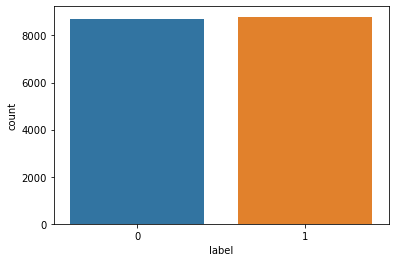

In [16]:
sns.countplot(train['label']);

O Grafico mostra que lidamos com um dataset perfeitamente balanceado. Isso é bom porque a análise será mais fácil de entender e interpretar a métrica de acurácia do modelo.

In [17]:
# Função para mostrar o wordcloud das palavras que mais aparecem nas reviews.

def plot_wordcloud(data, title):
    wordcloud = WordCloud(background_color='black',
                          stopwords=set(STOPWORDS),
                          max_words=200,
                          max_font_size=100,
                          random_state=17,
                          width=800,
                          height=400,
                          mask=None)
    wordcloud.generate(str(data))
    plt.figure(figsize=(15.0,10.0))
    plt.axis('off')
    plt.title(title)
    plt.imshow(wordcloud);

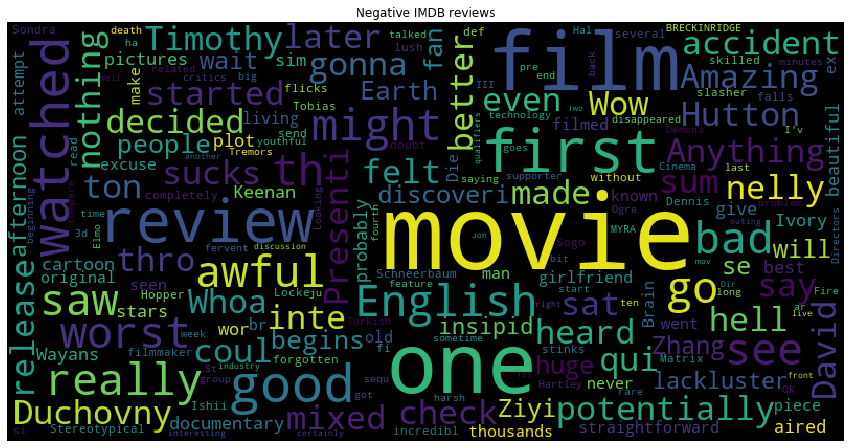

In [18]:
plot_wordcloud(train.loc[train['label']==0]['review'], 'Negative IMDB reviews')

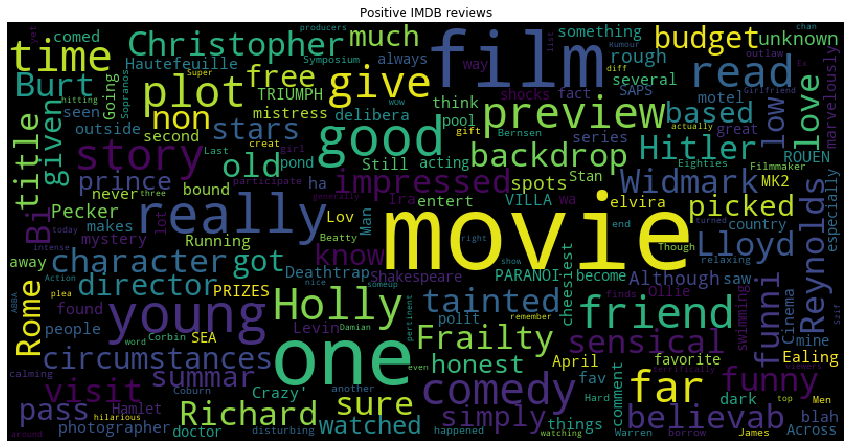

In [19]:
plot_wordcloud(train.loc[train['label']==1]['review'], 'Positive IMDB reviews')

Como podemos ver ambas as categorias as palavras que mais aparecem são "Movie" e "Film", e não é estranho, porque o dataset contem reviews de filmes.

Negative reviews contém palavras como: "Really" (pode ser usado de forma sarcástica ou para ampliar a opinião da pessoa), "Bad", "Disappointing", "Awful" (nada bom sobre o filme).

Positive reviews contém palavras como: "Best", "Epic", "Good" (que geralmente são usados para expressar a satisfação de alguém).